# Load Sensor Data

In [4]:
from sensor_data_loadder import SensorData
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

DATA_DIR = './walks/outside_elab/new/'
DATA_FILE = 'trax_2025_4_25_3_37_16_#28.csv'

sensorData = SensorData(data_dir=DATA_DIR, data_file=DATA_FILE)

Average sampling period: 0.0375 seconds
Approximate sampling frequency: 26.67 Hz


# Orientation Estimation using Accelerometer and Magnetometer Raw Data

In [5]:
from orientation_estimation import KalmanOrientationEstimator
import numpy as np
import matplotlib.pyplot as plt

initial_covariance = np.eye(3) * 0.1**2  # Example values for position/angle uncertainty
process_noise = np.diag([0.01**2, 0.01**2, 0.02**2])  # Accelerometer, Gyroscope, Magnetometer
measurement_noise = np.diag([0.2**2, 0.2**2, 0.3**2])  # Accelerometer, Gyroscope, Magnetometer
alpha = 0.7

kalmanFilter = KalmanOrientationEstimator(
    sensorData.acc_raw_data,
    sensorData.mag_raw_data,
    sensorData.gyro_raw_data,
    sensorData.timestamps_in_ms,
    initial_covariance=initial_covariance,
    process_noise=process_noise,
    measurement_noise=measurement_noise,
    alpha=alpha
)

roll_kf, pitch_kf, yaw_kf = kalmanFilter.compute_angles()

# Positon Estimtaion
## 1. Estimating Distances from GPS Data

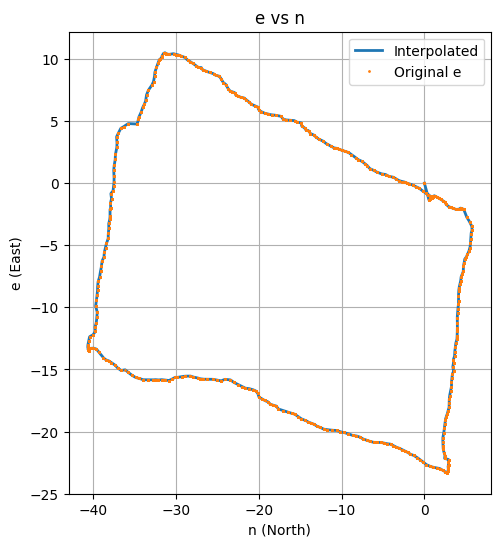

In [6]:
from pymap3d import geodetic2enu

# Example: GPS raw data: (N, 3) where each row is [lat, lon, alt]
# gps_raw_data = np.array([[lat1, lon1, alt1], [lat2, lon2, alt2], ..., [latN, lonN, altN]])

lat0, lon0, alt0 = sensorData.gps_raw_data[0]  # Origin for ENU conversion

# Initialize arrays to store ENU coordinates
e = np.zeros(sensorData.gps_raw_data.shape[0])  # East
n = np.zeros(sensorData.gps_raw_data.shape[0])  # North
u = np.zeros(sensorData.gps_raw_data.shape[0])  # Up

# Convert each GPS point (lat, lon, alt) to ENU
for i, (lat, lon, alt) in enumerate(sensorData.gps_raw_data):
    e[i], n[i], u[i] = geodetic2enu(lat, lon, alt, lat0, lon0, alt0)

gps_unique_timestamps_in_seconds = np.unique(sensorData.gps_timestamps_in_seconds)

# Stack the results into a single (N, 3) array for ENU positions
# Interpolation
interpolated_e = np.interp(sensorData.timestamps_in_seconds, sensorData.gps_timestamps_in_seconds, e)
interpolated_n = np.interp(sensorData.timestamps_in_seconds, sensorData.gps_timestamps_in_seconds, n)

# Plotting
plt.figure(figsize=(12, 6))

# Plot e vs n
plt.subplot(1, 2, 1)
plt.plot(interpolated_n, interpolated_e, '-', label='Interpolated', linewidth=2)
plt.plot(n, e, 'o', label='Original e', markersize=1)
plt.title('e vs n')  
plt.xlabel('n (North)')
plt.ylabel('e (East)')
plt.legend()
plt.grid()
plt.show()

### Estimating Position based on Accelerometer Data

[[0.02538196 0.18747087 0.43645052]
 [0.01496553 0.17155492 0.4346328 ]
 [0.01229988 0.15734922 0.43164041]
 ...
 [0.07133086 0.11245257 0.38868893]
 [0.07233036 0.11439993 0.39321288]
 [0.06896158 0.11186029 0.39394227]]


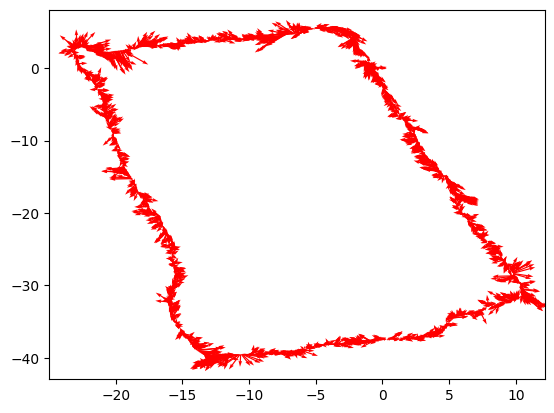

In [7]:
angles = np.array([roll_kf, pitch_kf, yaw_kf]) # roll, pitch, yaw
angles = np.transpose(angles)
print(angles)

# Create rotation matrices for roll, pitch, and yaw
def rotation_matrix(roll, pitch, yaw):
  # Rotation around x-axis (roll)
  R_x = np.array([[1, 0, 0],
                  [0, np.cos(roll), -np.sin(roll)],
                  [0, np.sin(roll), np.cos(roll)]])
  
  # Rotation around y-axis (pitch)
  R_y = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                  [0, 1, 0],
                  [-np.sin(pitch), 0, np.cos(pitch)]])
  
  # Rotation around z-axis (yaw)
  R_z = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                  [np.sin(yaw), np.cos(yaw), 0],
                  [0, 0, 1]])
  
  # Combined rotation matrix
  R = R_z @ R_y @ R_x  # Note the order of multiplication
  return R

# Rotate accelerometer measurements to world frame
acc_world = np.zeros_like(sensorData.acc_raw_data)  # shape: (N, 3)
for i in range(len(sensorData.acc_raw_data)):
  # Get the angles for the current measurement
  roll_angle = angles[i, 0]
  pitch_angle = angles[i, 1]
  yaw_angle = angles[i, 2]
  
  # Get the rotation matrix for the current angles
  R = rotation_matrix(roll_angle, pitch_angle, yaw_angle)
  
  # Rotate the accelerometer data
  acc_world[i] = R @ sensorData.acc_raw_data[i]  # R @ acc_body → acc_world

# Now acc_world contains the rotated accelerometer measurements

plt.quiver(interpolated_e, interpolated_n, 
           acc_world[:, 0], acc_world[:, 1], 
           angles='xy', scale_units='xy', color='r', label='Velocity Vectors', scale=2)